In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# transparentai package : https://github.com/Nathanlauga/transparentai
from transparentai.datasets import StructuredDataset, load_iris, load_adult, load_boston
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.explainer import ModelExplainer
from transparentai.models import ClassificationModel, RegressionModel
from transparentai.utils import encode_categorical_vars, labelencoder_to_dict

# transparentai.__SAVEPLOT__ = True

In [2]:
boston = load_boston()
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
dataset = StructuredDataset(df=boston,
                           target='MEDV'
                          )

#### Pearson correlation matrix for numerical variables

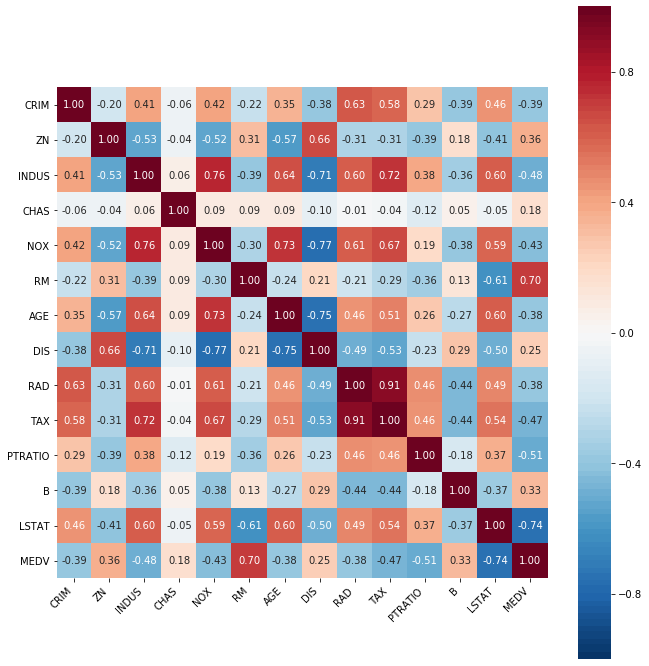

In [4]:
dataset.plot_correlations()

In [5]:
boston['age category'] = np.where(boston['AGE'] < 26, 'Young',
                                 np.where(boston['AGE'] < 61, 'Adult','Elder'))
dataset = StructuredDataset(df=boston,
                           target='MEDV'
                          )

In [6]:
privileged_groups = {
    'age category': ['Adult']
}
dataset_bias = DatasetBiasMetric(dataset=dataset,
                                 privileged_groups=privileged_groups)

In [7]:
# dataset_bias.plot_bias(attr='age ')

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
target = 'MEDV'
data = boston.drop(columns='age category')
X_reg, y_reg = data.drop(columns=target), data[target]
reg = LinearRegression().fit(X_reg, y_reg)

In [10]:
model = RegressionModel(model=reg)
model.compute_scores(X=X_reg, y=y_reg)

In [11]:
model.scores_dict

{'MAE': 3.2708628109003177,
 'MSE': 21.894831181729206,
 'RMSE': 21.894831181729206,
 'R2': 0.7406426641094094}

In [12]:
model.save_scores(fname='./regr_model_metrics.json')
model.scores_to_json()

{'MAE': 3.2708628109003177,
 'MSE': 21.894831181729206,
 'RMSE': 21.894831181729206,
 'R2': 0.7406426641094094}

In [13]:
adult = load_adult()
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [14]:
adult.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,age category
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,Young


In [15]:
dataset = StructuredDataset(df=adult,
                           target='income'
                          )

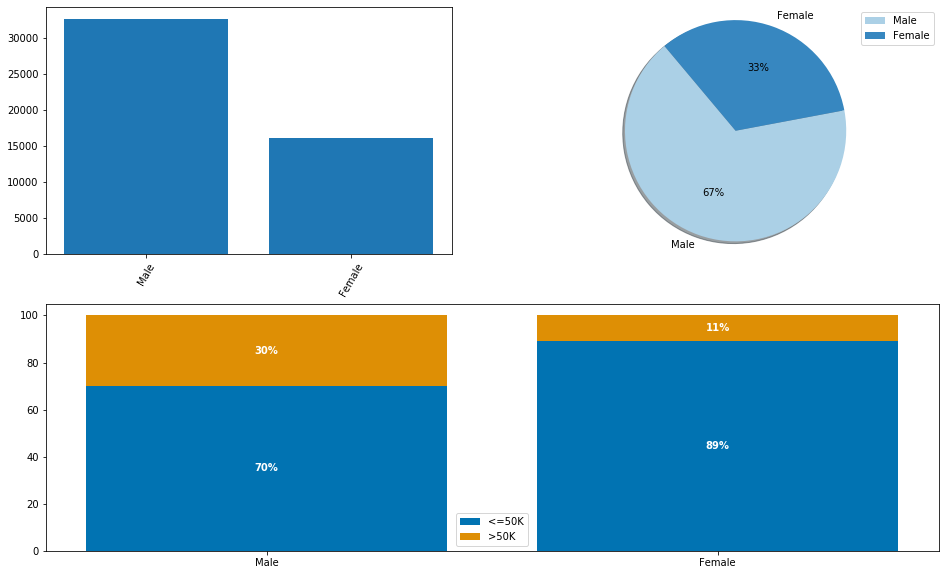

In [16]:
dataset.plot_cat_variable(var='gender')

In [17]:
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}
favorable_label = '>50K'
dataset_bias = DatasetBiasMetric(dataset=dataset,
                                 privileged_groups=privileged_groups,
                                 favorable_label=favorable_label)

In [18]:
dataset_bias.get_bias_metrics(attr='gender')

,Disparate impact,Statistical parity difference
>50K,0.359655,-0.194516


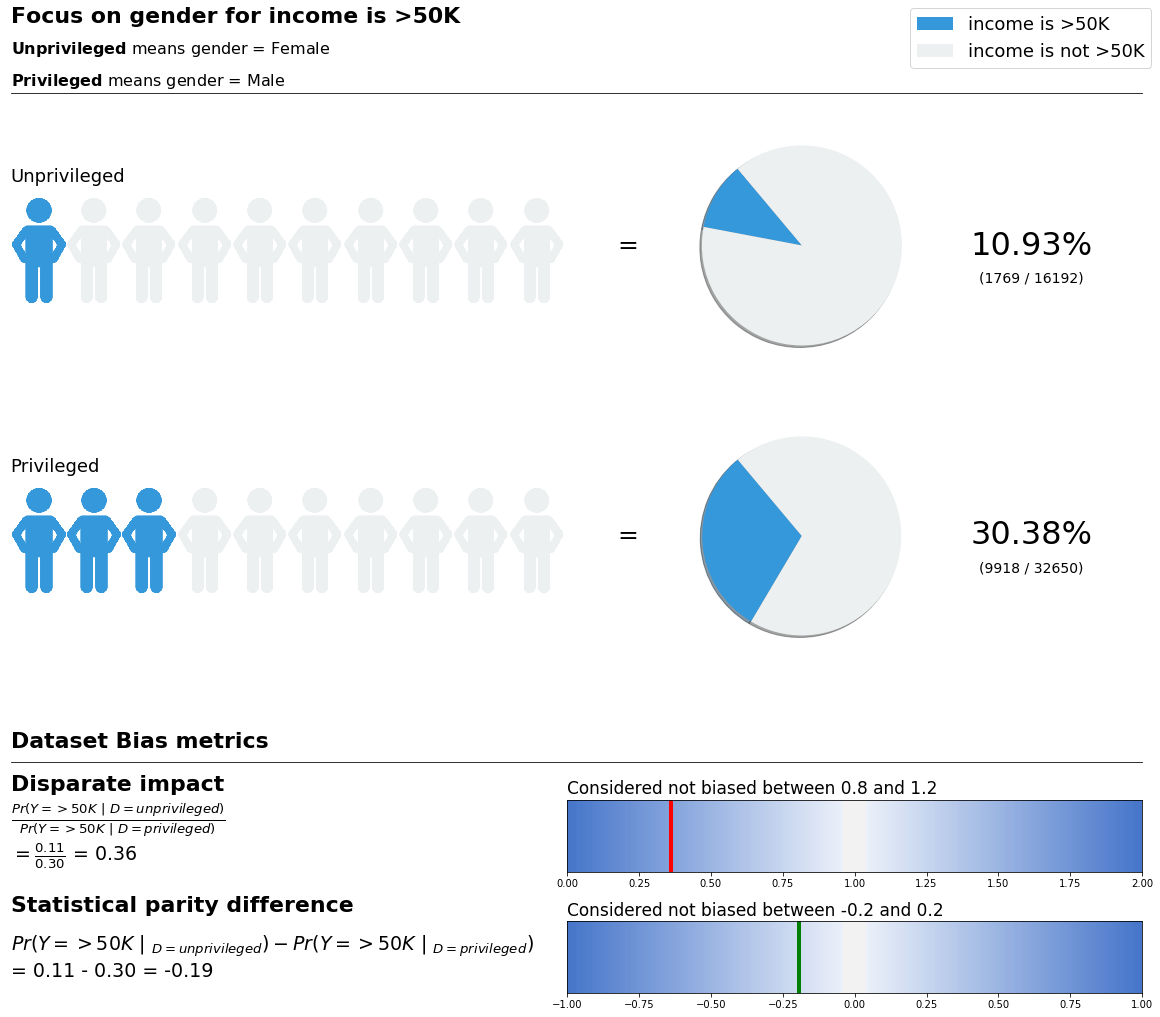

In [19]:
dataset_bias.plot_bias(attr='gender')

In [20]:
dataset_bias.insight(attr='gender')

{'gender': {'>50K': "For this target value regarding the 'gender' attribute 1 for the 2 bias metrics are/is biased so you can considered that the dataset is biased."}}

In [21]:
dataset_bias.save_bias_metrics(fname='test.json')
dataset_bias.metrics_to_json()

{'age category': {'>50K': '{"Disparate impact":0.2573115861,"Statistical parity difference":-0.222479073}'},
 'marital-status': {'>50K': '{"Disparate impact":0.1432990148,"Statistical parity difference":-0.3821063727}'},
 'race': {'>50K': '{"Disparate impact":0.6005915505,"Statistical parity difference":-0.1014445051}'},
 'gender': {'>50K': '{"Disparate impact":0.3596552626,"Statistical parity difference":-0.194515746}'}}

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# transparentai package : https://github.com/Nathanlauga/transparentai
from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.explainer import ModelExplainer
from transparentai.models import ClassificationModel
from transparentai.utils import encode_categorical_vars, labelencoder_to_dict

# transparentai.__SAVEPLOT__ = True
adult = load_adult()
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [3]:
target = 'income'
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)
adult, encoders = encode_categorical_vars(adult)
X, y = adult.drop(columns=target), adult[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [6]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(clf, file)
file.close()

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.854448,0.856255,0.858706,0.854448,[0.9104387547348203]


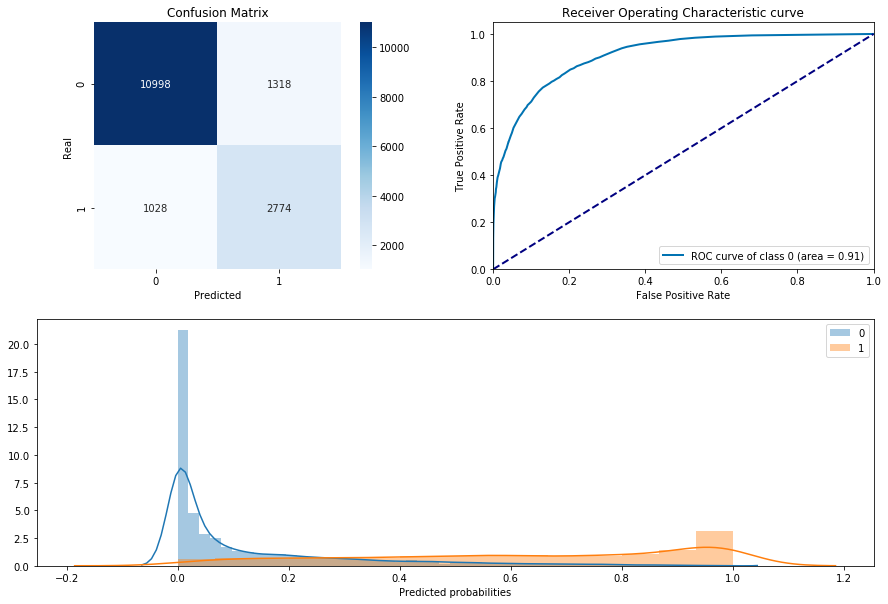

In [4]:
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test, threshold=0.4)
model.plot_scores()

In [25]:
model.save_scores(fname='./clf_model_metrics.json')
model.scores_to_json()

{'accuracy': 0.8544484427348307,
 'f1': 0.8562549702294708,
 'precision': 0.8587056101645184,
 'recall': 0.8544484427348307,
 'roc_auc': [0.9104387547348203]}

In [26]:
TP = model.get_true_positives()
TN = model.get_true_negatives()
FP = model.get_false_positives()
FN = model.get_false_negatives()
len(TP), len(TN), len(FP), len(FN)

(2774, 10998, 1318, 1028)

## Proba threshold comparison for accuracy, f1 score, precision & recall

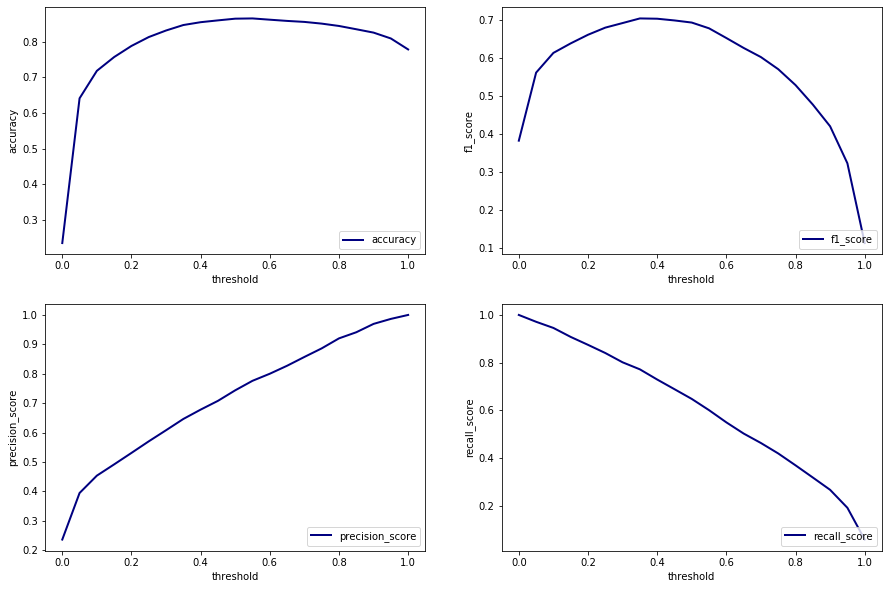

In [27]:
model.plot_threshold()

In [28]:
pd.Series(clf.predict(X_test)).value_counts()

0    12879
1     3239
dtype: int64

In [29]:
target = 'income'
df = X_test.copy()

for feature, encoder in encoders.items():
    df[feature] = encoder.inverse_transform(df[feature])

target_value = {0:'<=50K', 1:'>50K'}
df[target] = y_test.replace(target_value)

dataset = StructuredDataset(df=df, target=target)
preds = pd.Series(clf.predict(X_test)).replace(target_value)
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}
favorable_label = '>50K'

In [30]:
model_bias = ModelBiasMetric(dataset=dataset,
                             preds=preds,
                             privileged_groups=privileged_groups,
                             favorable_label=favorable_label)

In [31]:
model_bias.get_bias_metrics(attr='gender')

,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
>50K,0.302189,-0.182018,-0.105678,0.087605,0.107743


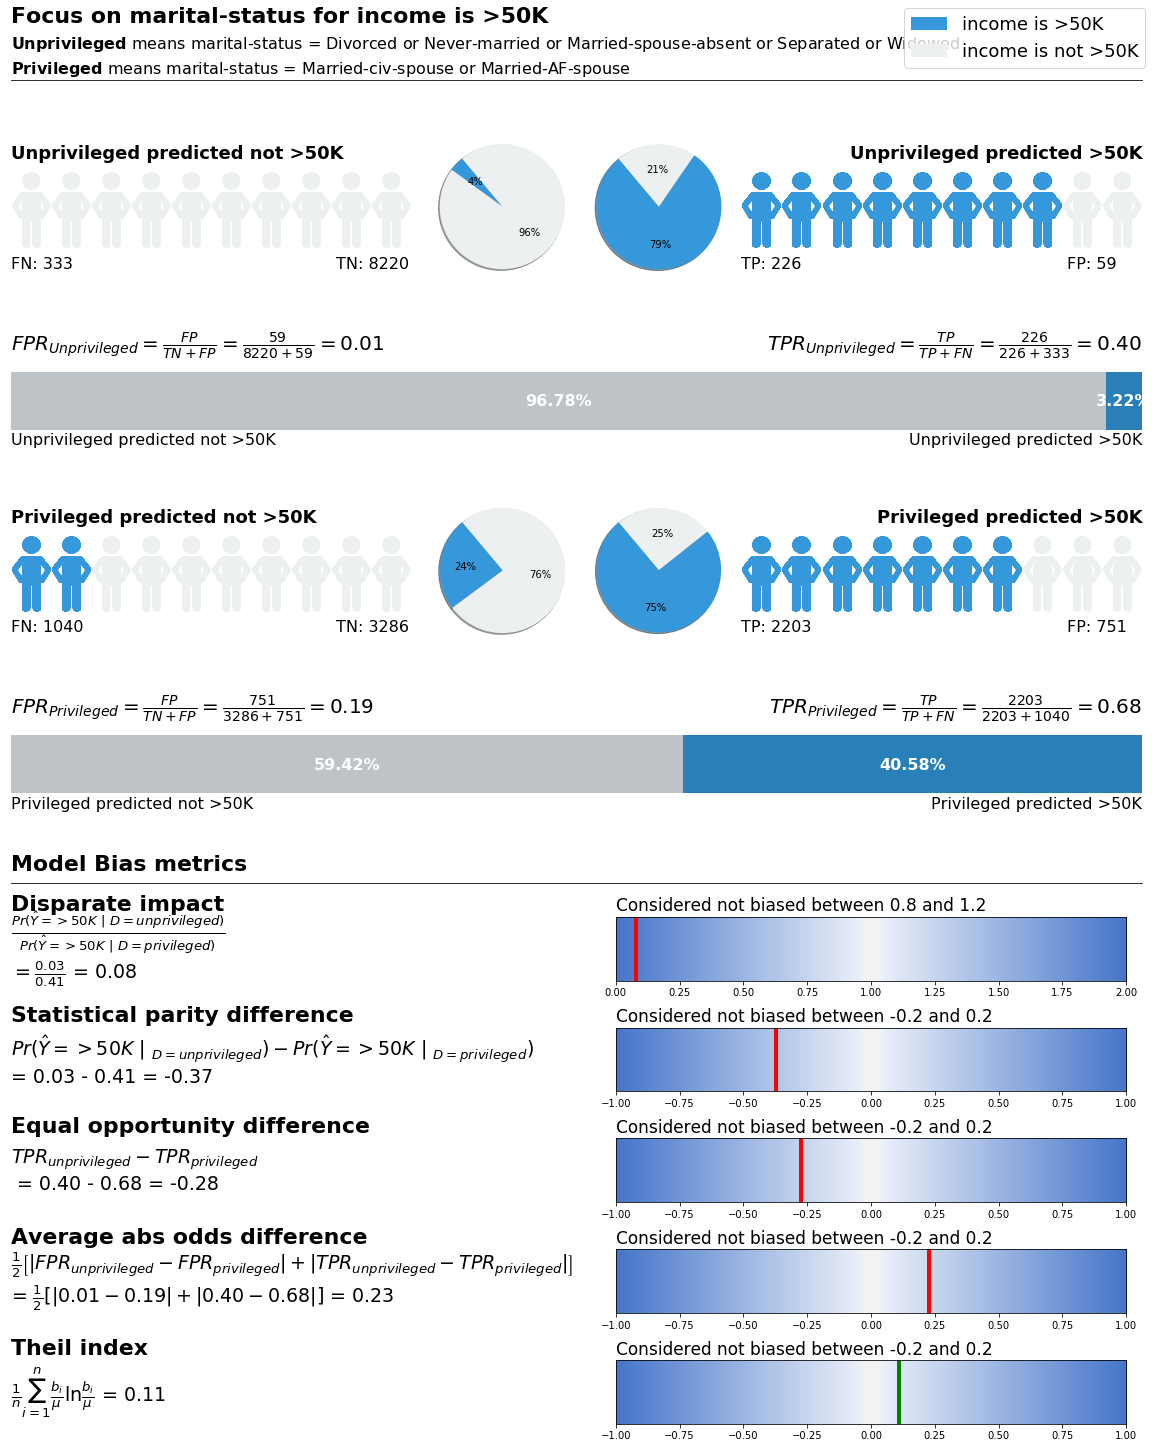

In [32]:
model_bias.plot_bias(attr='marital-status')

In [33]:
model_bias.get_bias_metrics()

,,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
attr,index,,,,,
age category,>50K,0.239931,-0.192626,-0.086698,0.077004,0.107743
marital-status,>50K,0.079472,-0.373522,-0.275016,0.226959,0.107743
race,>50K,0.516296,-0.104626,-0.043202,0.041003,0.107743
gender,>50K,0.302189,-0.182018,-0.105678,0.087605,0.107743


In [35]:
model_bias.save_bias_metrics(fname='test.json')
model_bias.metrics_to_json()

{'age category': {'>50K': '{"Disparate impact":0.2399307681,"Statistical parity difference":-0.1926260559,"Equal opportunity difference":-0.0866979077,"Average abs odds difference":0.0770036441,"Theil index":0.1077434355,"attr":"age category"}'},
 'marital-status': {'>50K': '{"Disparate impact":0.0794715624,"Statistical parity difference":-0.373522116,"Equal opportunity difference":-0.2750159005,"Average abs odds difference":0.2269593328,"Theil index":0.1077434355,"attr":"marital-status"}'},
 'race': {'>50K': '{"Disparate impact":0.5162956959,"Statistical parity difference":-0.1046255856,"Equal opportunity difference":-0.0432015489,"Average abs odds difference":0.041002567,"Theil index":0.1077434355,"attr":"race"}'},
 'gender': {'>50K': '{"Disparate impact":0.3021886109,"Statistical parity difference":-0.1820181164,"Equal opportunity difference":-0.1056775302,"Average abs odds difference":0.0876053944,"Theil index":0.1077434355,"attr":"gender"}'}}

In [33]:
iris = load_iris()
target = 'iris plant'
iris[target] = iris[target].replace({'setosa':0, 'versicolor':1, 'virginica':2})
clf2 = RandomForestClassifier()
X, y = iris.drop(columns=target), iris[target]
clf2.fit(X, y)
model = ClassificationModel(model=clf2)
model.compute_scores(X=X, y=y)
model.scores_to_json()

{'accuracy': 1.0,
 'f1': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'roc_auc': [1.0, 1.0, 1.0]}

In [11]:
insight = model_bias.insight(attr='gender')
for attr in insight:
    print(attr)
    for target_value in insight[attr]:
        print(target_value)
        print(insight[attr][target_value])

gender
>50K
For this target value regarding the 'gender' attribute 3 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.


In [12]:
insight

{'gender': {'>50K': "For this target value regarding the 'gender' attribute 3 for the 5 bias metrics are/is biased so you can considered that the dataset is biased."}}

In [29]:
test = pd.DataFrame([[1,2],[1,2]])
test2 = pd.DataFrame([[2,2],[1,2]])
np.all(test == test2)

False

In [30]:
feature_names = X_reg.columns
explainer = ModelExplainer(model=reg, X=X_reg, feature_names=feature_names, model_type='linear')
row = X_reg.iloc[6]

{'CRIM=0.08829': 0.380765263217142,
 'ZN=12.5': 0.05275052087145104,
 'INDUS=7.87': -0.0671604818152232,
 'CHAS=0.0': -0.18584127208907195,
 'NOX=0.524': 0.5453471850090842,
 'RM=6.0120000000000005': -1.0387002665512861,
 'AGE=66.6': -0.0013670752630462592,
 'DIS=5.5605': -2.6050502772830018,
 'RAD=5.0': -1.3923436771222797,
 'TAX=311.0': 1.1993808100460737,
 'PTRATIO=15.2': 3.1017006221174346,
 'B=395.6': 0.3624662886751244,
 'LSTAT=12.43': 0.11705430456235152}

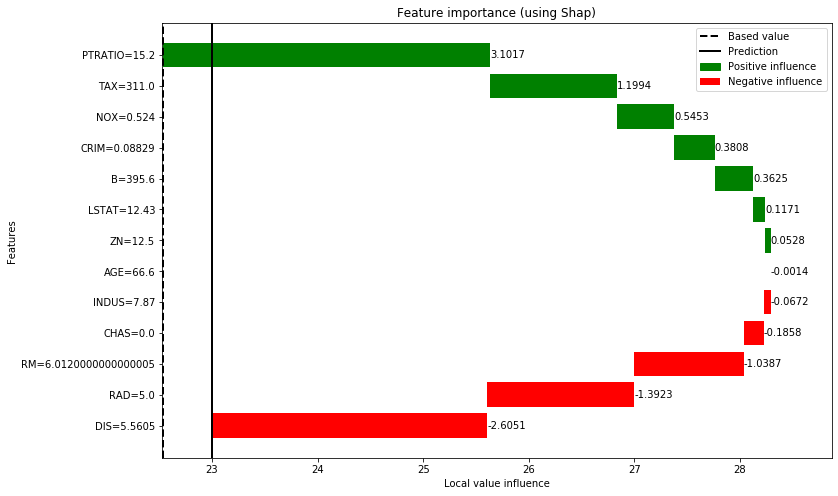

In [31]:
display(explainer.explain_local(row))
explainer.plot_local_explain(row)

In [43]:
explainer.explain_global(X_reg.iloc[0:10])

SAME


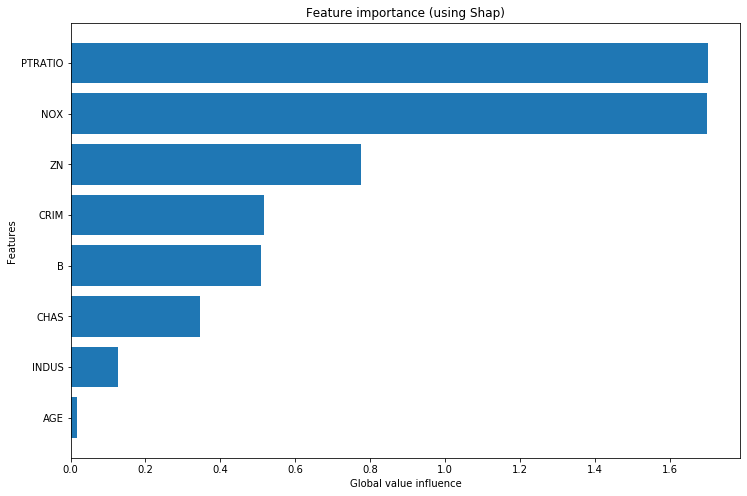

In [42]:
# explainer.explain_global(X_reg)
explainer.plot_global_explain(X_reg, top=8)

In [44]:
feature_names = X_test.columns
explainer = ModelExplainer(model=clf, X=X_train, 
                           feature_names=feature_names, model_type='tree')

{'age=54': 0.059892973252285625,
 'workclass=4': 0.0038530879129211825,
 'fnlwgt=146834': -0.010423916191489297,
 'education=11': -0.006899380215309066,
 'education-num=9': -0.08579990384067969,
 'marital-status=0': -0.024170761174491417,
 'occupation=14': -0.007132229182188894,
 'relationship=1': -0.08073260560940071,
 'race=4': -0.0009058608048417228,
 'gender=1': 0.0076747944971066314,
 'capital-gain=0': -0.01141759495571023,
 'capital-loss=0': -0.006954920665048121,
 'hours-per-week=45': 0.023795806189400536,
 'native-country=39': -0.0019305555959545017,
 'age category=0': 0.003751067780467565}

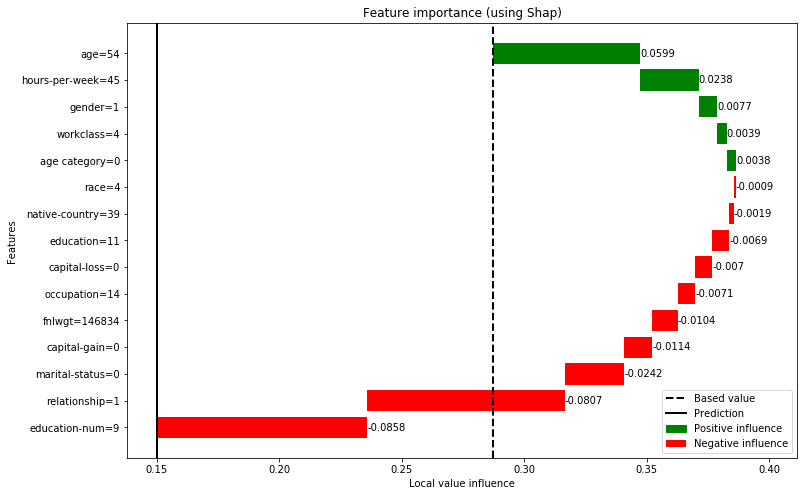

In [45]:
row = X_test.iloc[6]
display(explainer.explain_local(row))
explainer.plot_local_explain(row)

In [46]:
import shap
test = shap.sample(X_test, 100)
explainer.explain_global(test)

 96%|=================== | 191/200 [00:16<00:00]       

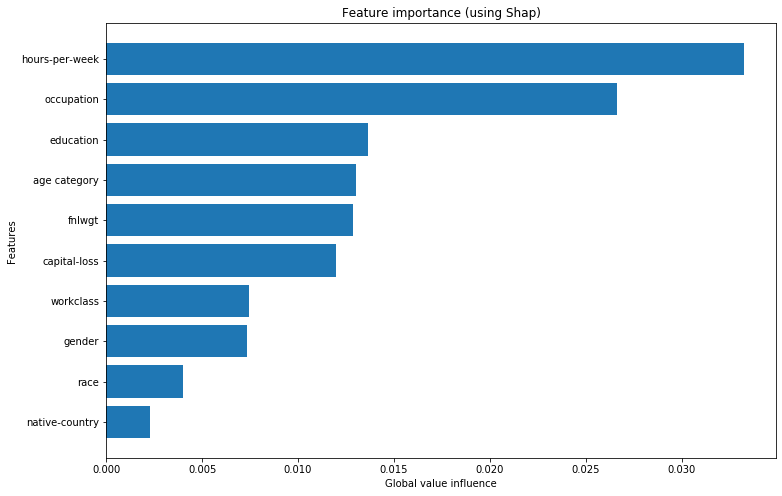

In [48]:
explainer.plot_global_explain(top=10)

No missing value.

### Numerical variables

**age :** 0 nulls, 71 unique vals, most common: {23: 476, 36: 451}

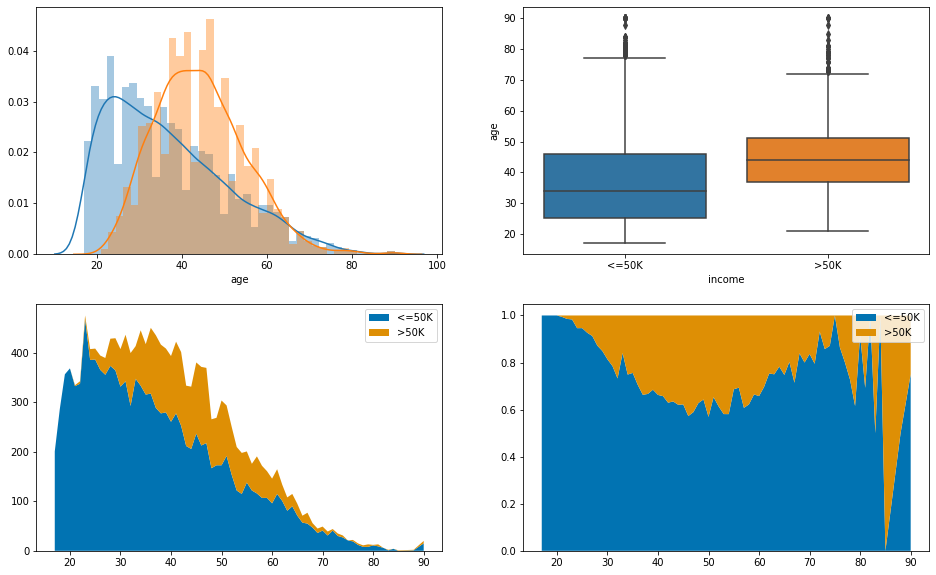

**fnlwgt :** 0 nulls, 12701 unique vals, most common: {120277: 10, 203488: 10}

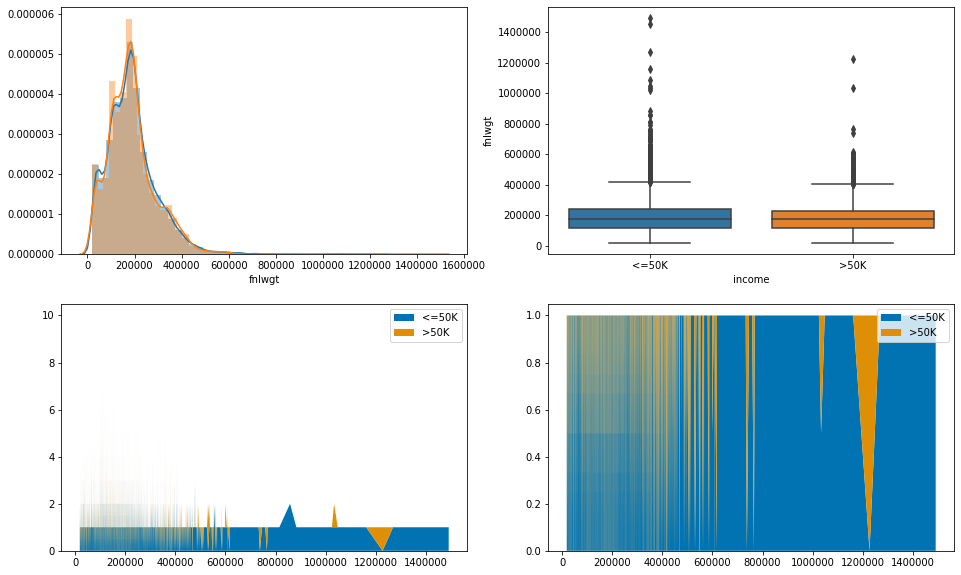

**education-num :** 0 nulls, 16 unique vals, most common: {9: 5237, 10: 3515}

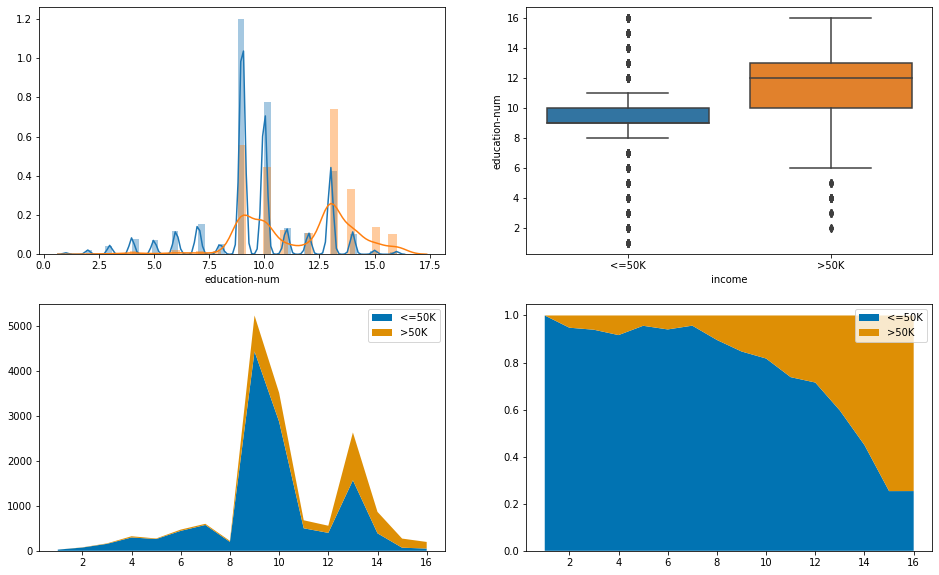

**capital-gain :** 0 nulls, 109 unique vals, most common: {0: 14777, 15024: 177}

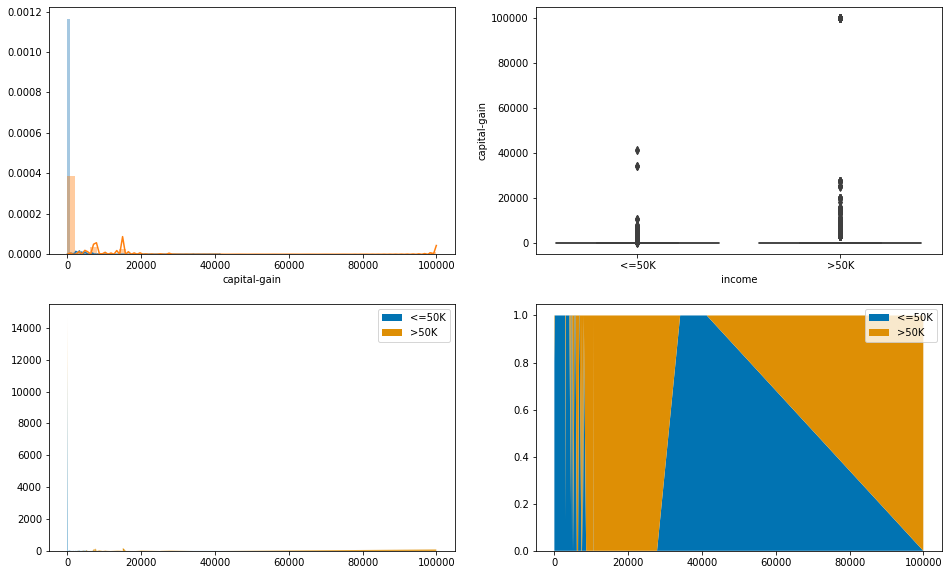

**capital-loss :** 0 nulls, 84 unique vals, most common: {0: 15406, 1902: 98}

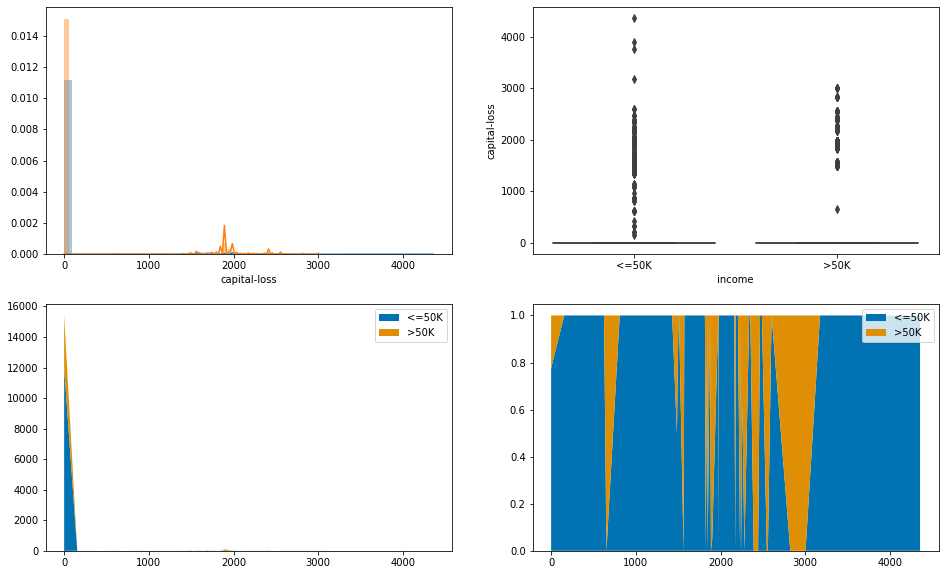

**hours-per-week :** 0 nulls, 86 unique vals, most common: {40: 7534, 50: 1378}

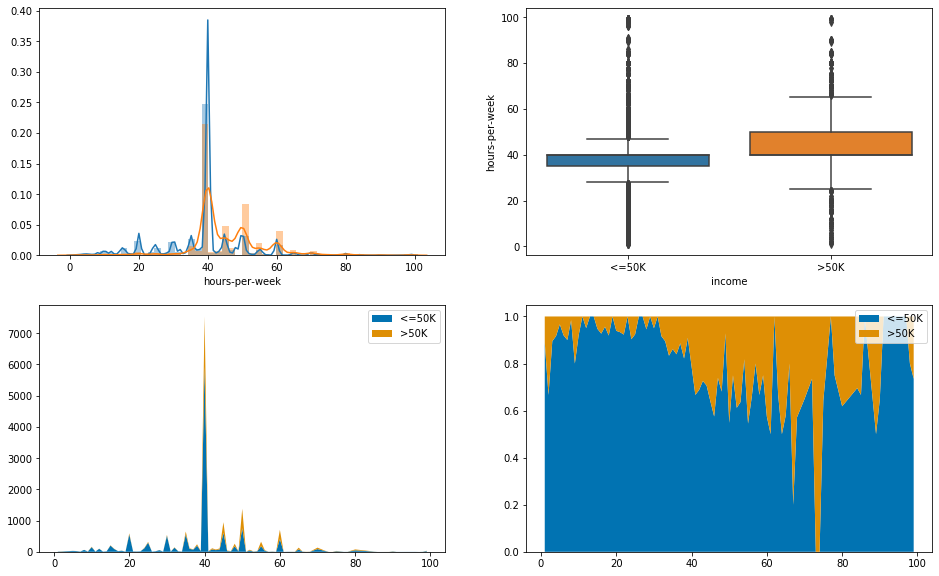

### Categorical variables

**workclass :** 0 nulls, 9 unique vals, most common: {'Private': 11239, 'Self-emp-not-inc': 1294}

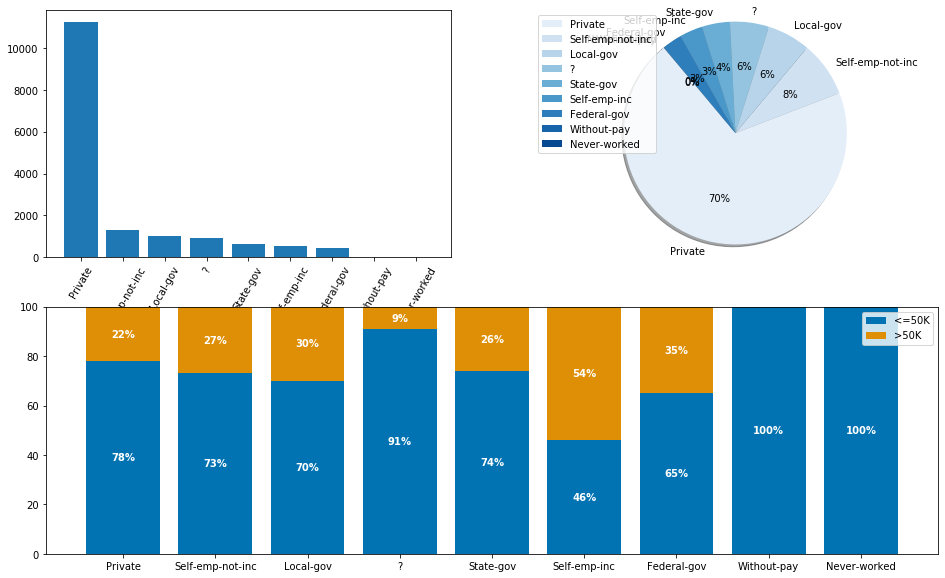

**education :** 0 nulls, 16 unique vals, most common: {'HS-grad': 5237, 'Some-college': 3515}

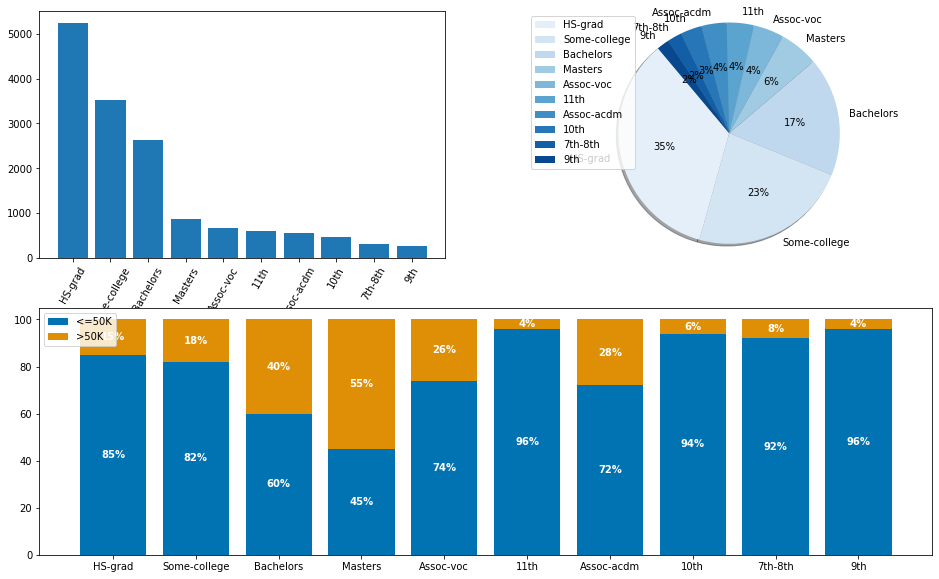

**marital-status :** 0 nulls, 7 unique vals, most common: {'Married-civ-spouse': 7268, 'Never-married': 5418}

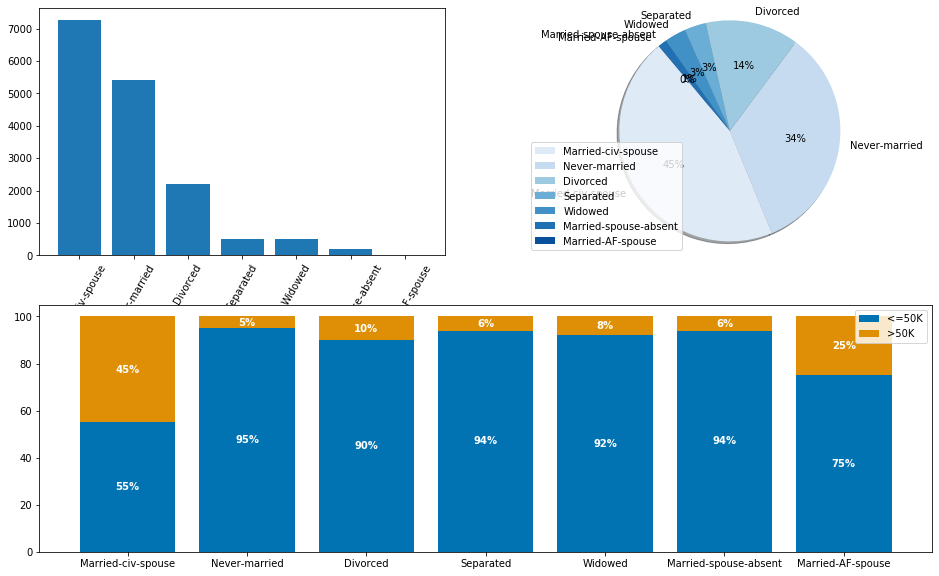

**occupation :** 0 nulls, 15 unique vals, most common: {'Craft-repair': 2025, 'Exec-managerial': 2015}

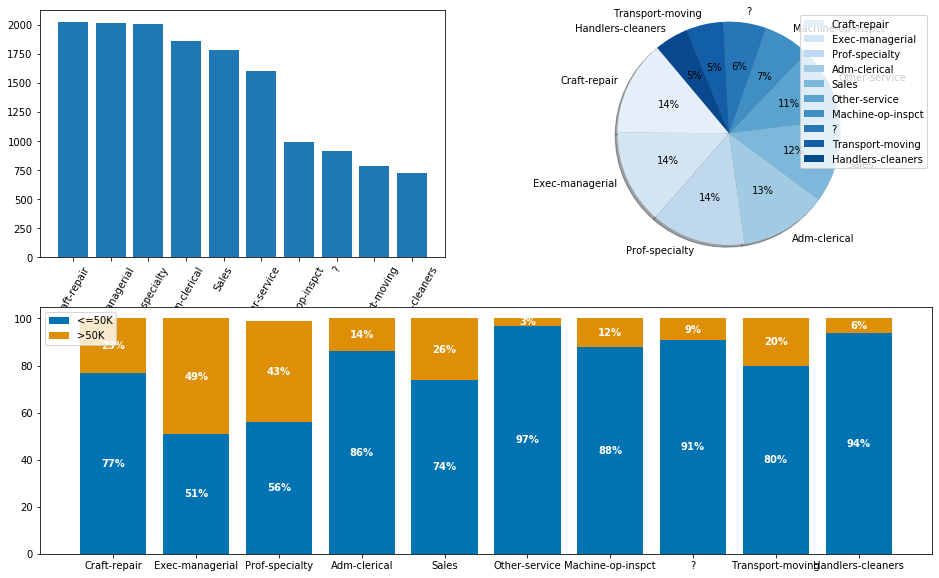

**relationship :** 0 nulls, 6 unique vals, most common: {'Husband': 6401, 'Not-in-family': 4178}

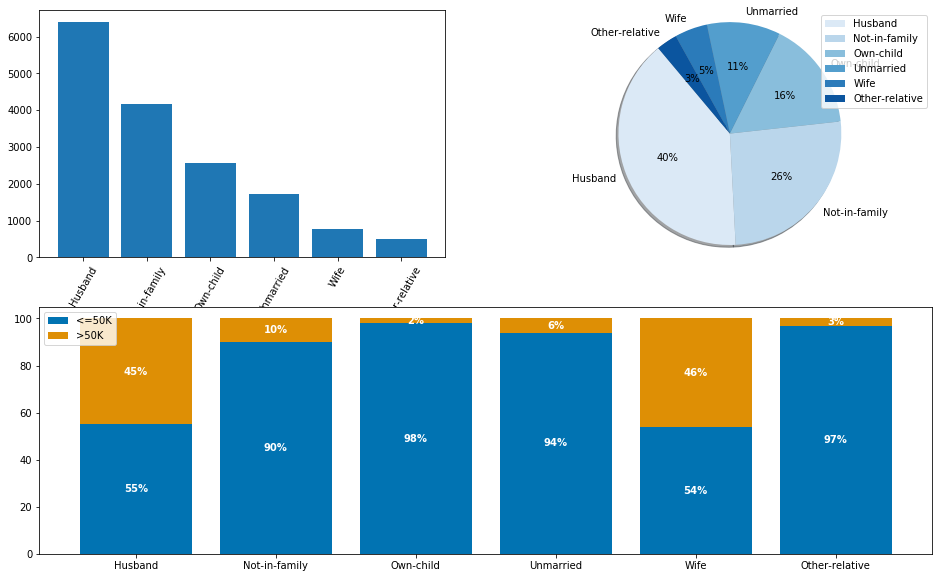

**race :** 0 nulls, 5 unique vals, most common: {'White': 13754, 'Black': 1600}

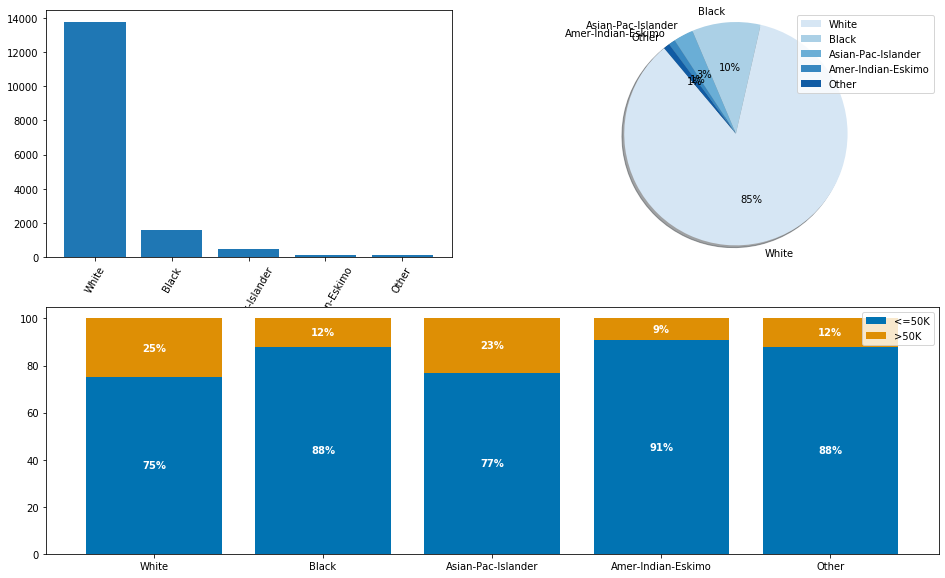

**gender :** 0 nulls, 2 unique vals, most common: {'Male': 10815, 'Female': 5303}

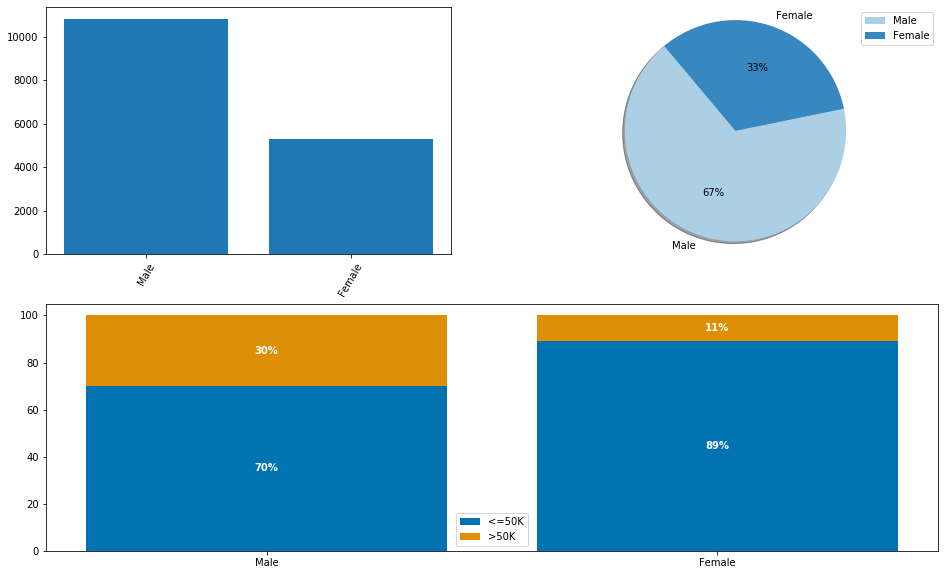

**native-country :** 0 nulls, 41 unique vals, most common: {'United-States': 14487, 'Mexico': 305}

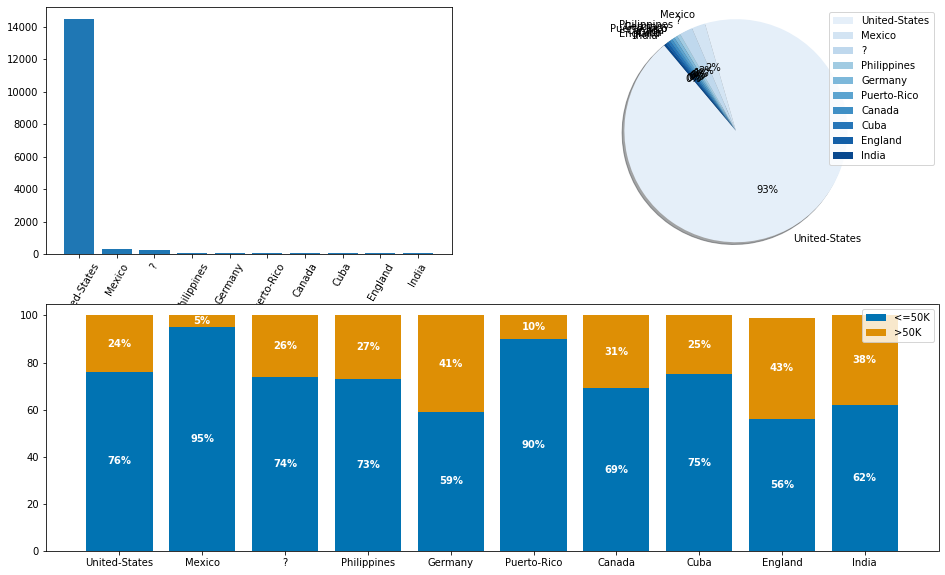

**age category :** 0 nulls, 3 unique vals, most common: {'Adult': 11727, 'Young': 3185}

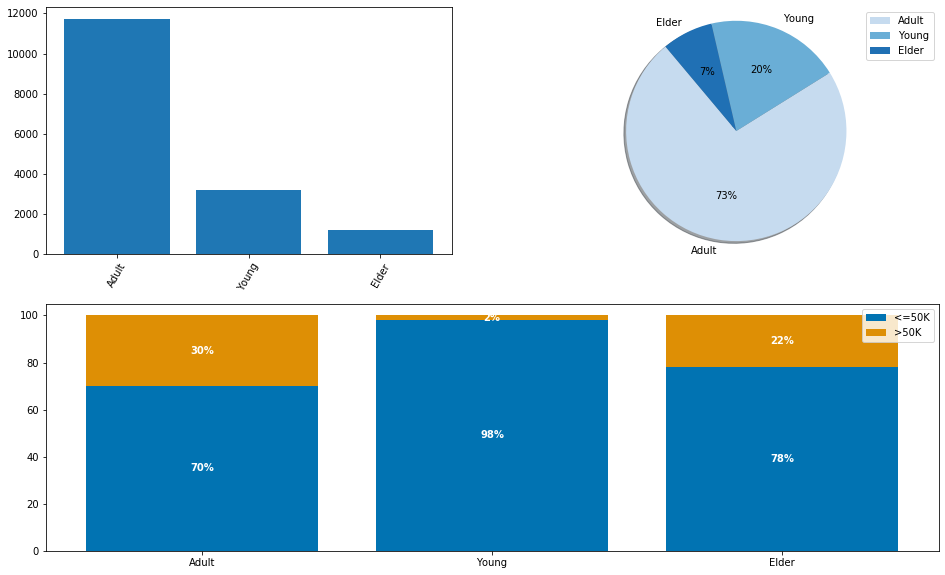

**income :** 0 nulls, 2 unique vals, most common: {'<=50K': 12316, '>50K': 3802}

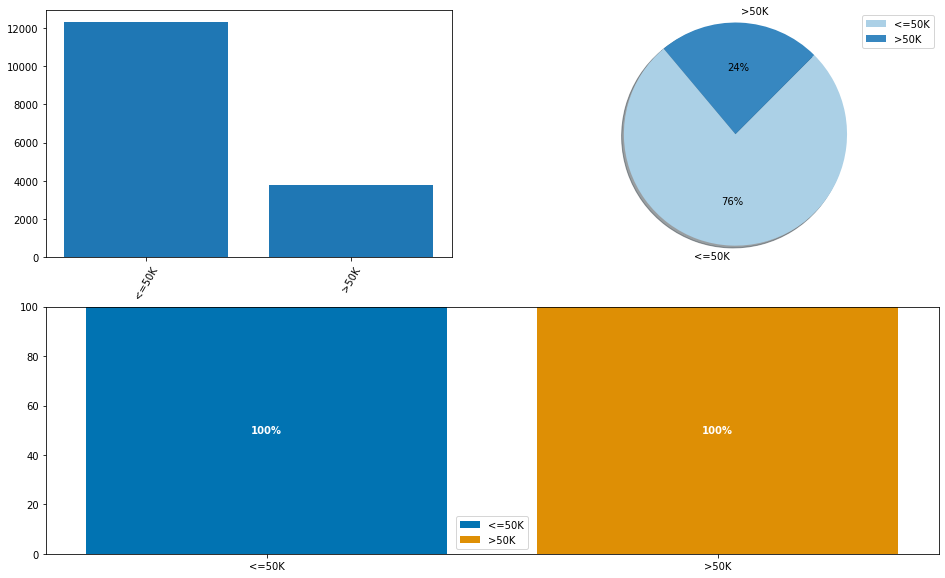

### Datetime variables

ValueError: The variable was not found inside the columns data

In [23]:
# Understand my data
dataset.plot_missing_values()

dataset.plot_variables()
dataset.plot_num_variable(var='var')
dataset.plot_cat_variable(var='var')
dataset.plot_datetime_variable(var='var')

dataset.plot_variables_scatter()
dataset.plot_scatter_two_variables(var1='var1', var2='var2')

dataset.plot_variables_boxplot()
dataset.plot_boxplot_two_variables(cat_var='cat_var', num_var='num_var')

dataset.plot_correlations()

# show bias
dataset_bias = DatasetBiasMetric(dataset=dataset,
                                 privileged_groups=privileged_groups)
dataset_bias.get_bias_metrics(attr='attr')

dataset_bias.plot_bias(attr='attr', target_value='1')
dataset_bias.display_insight(attr='attr', target_value='1')


# Model
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test, threshold=0.5)
model.plot_scores()
model.plot_threshold()

# show bias
